In [42]:
import os
import kagglehub
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image

"""
    Image loading and preprocessing
"""

image_size = 72

dataset_path = kagglehub.dataset_download("subinium/emojiimage-dataset")
description = pd.read_csv(dataset_path + '/full_emoji.csv')
names = description['name'] # to sie przyda jako label zwracany, potem do Flaska

image_data = []
labels = []

dataset_path += '/image'
for dir in os.listdir(dataset_path):
    temp_path = dataset_path + f'/{dir}'
    for image_name in os.listdir(temp_path):
        image = Image.open(temp_path + f'/{image_name}')\
            .convert('RGBA')
        
        to_append = np.array(image).T / 255.
        if to_append.shape == (4, 72, 72): # majority of the data
            image_data.append(
                to_append
            )
            labels.append(
                image_name.split('.')[0]
            )

In [62]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256
labels_encoded = pd.get_dummies( np.array(labels, dtype=int) ).to_numpy()
image_data = np.array(image_data)

image_train, image_test, label_train, label_test = train_test_split(image_data, labels_encoded, test_size=0.15)

image_dataset = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.Tensor(image_train),
        torch.Tensor(label_train)
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

image_test = torch.Tensor(image_test).float().cuda()
label_test  = torch.Tensor(label_test).int().cuda()

In [64]:
class CNN(nn.Module):
    def __init__(self, layers, lr):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = torch.optim.RMSprop(self.parameters(), lr)
        self.loss = nn.CrossEntropyLoss()
        self.to('cuda')

    def forward(self, input):
        return self.layers(input)
    
layers = [
    nn.LazyConv2d(4, kernel_size=3, stride=2), nn.ReLU(),
    nn.LazyConv2d(3, kernel_size=4), nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(512), nn.ReLU(),
    nn.LazyLinear(128), nn.ReLU(),

    nn.LazyLinear(32), nn.ReLU(),
    nn.LazyLinear(8), nn.ReLU(),
    nn.LazyLinear(labels_encoded.shape[1]), nn.Sigmoid(),
]

model = CNN(layers, 1e-3)

EPOCHS = 100
loss_history = np.zeros(EPOCHS)

model.train()

for epoch in range(EPOCHS):
    for training_batch, label_batch in image_dataset:
        training_batch = training_batch.cuda()
        label_batch = label_batch.cuda()

        model.optim.zero_grad()
        output = model(training_batch).reshape( *label_batch.shape )
        loss = model.loss(output, label_batch)
        loss.backward()
        model.optim.step()
    print(f'\r{epoch / (EPOCHS - 1)*100 :.2f}%', end='', flush=True)

    loss_history[epoch] = loss.item()

model.eval()

100.00%

CNN(
  (layers): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 3, kernel_size=(4, 4), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3072, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=8, bias=True)
    (12): ReLU()
    (13): Linear(in_features=8, out_features=1816, bias=True)
    (14): Sigmoid()
  )
  (loss): CrossEntropyLoss()
)

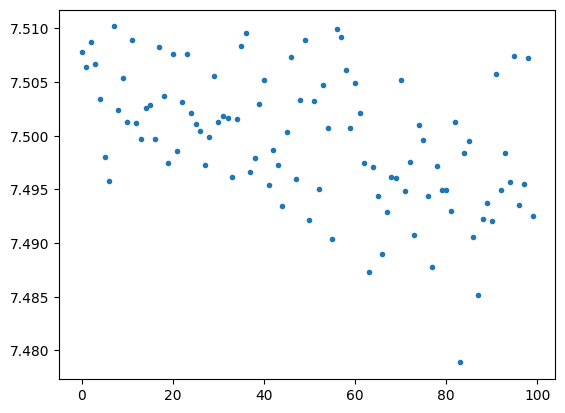

In [65]:
import matplotlib.pyplot as plt

plt.plot(loss_history, 'o', markersize=3)

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

label_pred = model(image_test).detach().cpu()
accuracy_score( label_test.cpu().argmax(dim=-1, keepdim=True), label_pred.cpu().argmax(dim=-1, keepdim=True))
# confusion = confusion_matrix(label_test, output_test)

# ConfusionMatrixDisplay(confusion).plot()

0.0008200082000820008